# Clothing Fashion Model

The purpose of this notebook is to create a classification model for different clothing items. The open-source image dataset used for training the classifier on is from github alexygrigorev -> https://github.com/alexeygrigorev/clothing-dataset. I had tried Fashion minst dataset, it was easy to work with and had good test set accuracy but it did not adapt well to real world images, so I found a dataset with higher quality images with normal backgrounds rather than transparent and cropped images

In [1]:
# base libraries for manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to modify images
from PIL import Image

# for model fitting
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# utility libraries
import os
import shutil


C:\Users\Qasim\AppData\Local\Temp/ipykernel_21272/464263717.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Data Input

In [2]:
dataset_path = "..\clothing-dataset\images.csv"
dataset = pd.read_csv(dataset_path)

In [3]:
dataset.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


The data directory contains the csv shown above and images stored as .jpg. Each name in the 'image' column corresponds to the image in the images directory

In [4]:
# lets see the distribution of classes
gb_categories = dataset.groupby('label').count()

<AxesSubplot:xlabel='label'>

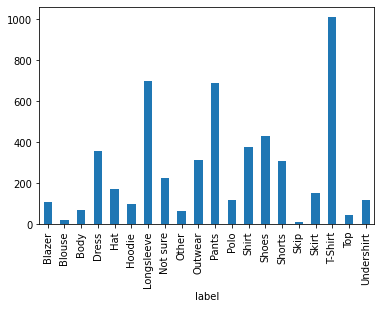

In [5]:
gb_categories['image'].plot.bar()

We can quickly see that the distribution of records per class is not great. Most of the images are for T-shirts and a few in between and some such as skirt have very few records. In order to make a better classifer we need more balanced dataset of images

In [6]:
# lets narrow down number of classes which have relatively high number of records, so when we upscale dataset we'll have a few more examples to build from
gb_categories[gb_categories['image'] > 200]

,image,sender_id,kids
label,,,
Dress,357,357,357
Longsleeve,699,699,699
Not sure,228,228,228
Outwear,312,312,312
Pants,692,692,692
Shirt,378,378,378
Shoes,431,431,431
Shorts,308,308,308
T-Shirt,1011,1011,1011


## Prepairing dataset

In [7]:
# Chose a subset of classes with more data
dict_labels = {'T-Shirt':0, 'Pants':1, 'Longsleeve':2, 'Dress':3, 'Shoes':4}
lookup = {value: key for key, value in dict_labels.items()}

In [8]:
# label encode the class names to prep data for training for tensorflow
dataset = dataset.query(f"label in {[*dict_labels]}")

In [9]:
# taking the X as image and y as label for classification
df_main = dataset[['image','label']]
df_main['y'] = df_main['label'].replace(dict_labels)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_21272/2490017833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['y'] = df_main['label'].replace(dict_labels)


In [10]:
# add image path column next image names, so they are easy to extract into images
df_main['img_path'] = df_main['image'].apply(lambda x: f"../clothing-dataset/images/{x}.jpg")

## Setup Training data in directories for Keras

In [11]:
# go through dataset and make directory for each class
for i,r in df_main.iterrows():

    new_path = f'../clothing-dataset/data/{r["label"]}/{r["image"]+".jpg"}'
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    old_path = r['img_path']

    # copy to new path
    shutil.copy(old_path, new_path)

In [12]:
path_images_directory = "../clothing-dataset/data"
# path_images_directory = "C://Users//Qasim//Desktop//dress"


In [13]:
# parameters for the model
batch_size = 32
img_height = 224
img_width = 224

In [14]:
# read images from directory and setup preprocesing pipeline
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_images_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3230 files belonging to 5 classes.
Using 2584 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path_images_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3230 files belonging to 5 classes.
Using 646 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Dress', 'Longsleeve', 'Pants', 'Shoes', 'T-Shirt']


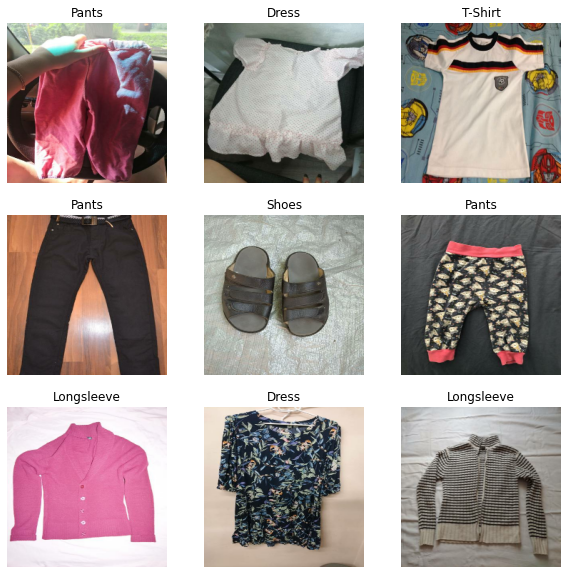

In [17]:
# view a few samples of images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# start to normalize layers with pixel values b/w [0 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0012207642 0.95871425


## Setup Models to train

In [22]:
# simple model init
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
81/81 [==============================] - 9s 34ms/step - loss: 1.2722 - accuracy: 0.5008 - val_loss: 0.9612 - val_accuracy: 0.6904
Epoch 2/10
81/81 [==============================] - 2s 19ms/step - loss: 0.8334 - accuracy: 0.7059 - val_loss: 0.7833 - val_accuracy: 0.7322
Epoch 3/10
81/81 [==============================] - 1s 18ms/step - loss: 0.6057 - accuracy: 0.7899 - val_loss: 0.6733 - val_accuracy: 0.7817
Epoch 4/10
81/81 [==============================] - 1s 18ms/step - loss: 0.3915 - accuracy: 0.8665 - val_loss: 0.6795 - val_accuracy: 0.7802
Epoch 5/10
81/81 [==============================] - 1s 18ms/step - loss: 0.2356 - accuracy: 0.9280 - val_loss: 0.7548 - val_accuracy: 0.7663
Epoch 6/10
81/81 [==============================] - 1s 18ms/step - loss: 0.1208 - accuracy: 0.9663 - val_loss: 0.7505 - val_accuracy: 0.7957
Epoch 7/10
81/81 [==============================] - 1s 18ms/step - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.7790 - val_accuracy: 0.7864
Epoch 8/10
81

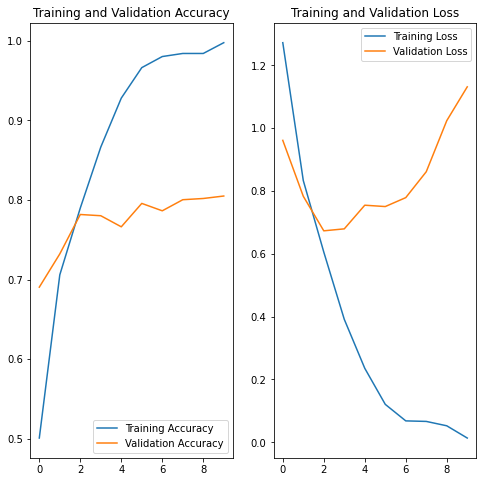

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the image above we can see that the model become overfit on the training data, the validation loss starts increasing but training loss drops. We need them to be very close to each other

## Data Augmentation

In [27]:
## we need to start augmenting image data with a few variations so the model can see more variations of images for training
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

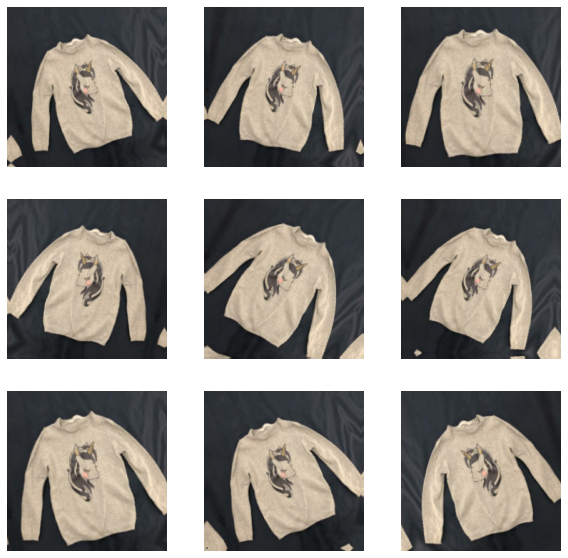

In [28]:
# display a few variations of class
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [29]:
# since dataset is imbalanced set the correct class wieghts
from sklearn.utils import class_weight

train_label = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_label),
                                                 y = train_label)

class_weights = dict(zip(np.unique(train_label), class_weights))

In [92]:
# More complex problem 
model = Sequential([
  data_augmentation, # augmented images so model sees a variation of training data
  layers.Rescaling(1./255), # rescale pixel values betwen 0 and 1 rather than 255 (helps with minimizing loss)
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3,3), # add maxpooling layers so the model identify more important features from images (after pooling nearby pixels to)
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3,3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)), # L2 regularizer helps balance the weight decay for each class
  layers.Dense(num_classes) 
])


In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              

In [94]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 24, 64)      

In [95]:
epochs = 60
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weights,
  callbacks=early_stopping
)


Epoch 1/60
81/81 [==============================] - 3s 20ms/step - loss: 2.1944 - accuracy: 0.1680 - val_loss: 1.6021 - val_accuracy: 0.2771
Epoch 2/60
81/81 [==============================] - 1s 18ms/step - loss: 1.5252 - accuracy: 0.3274 - val_loss: 1.3442 - val_accuracy: 0.4505
Epoch 3/60
81/81 [==============================] - 1s 17ms/step - loss: 1.3481 - accuracy: 0.4501 - val_loss: 1.1720 - val_accuracy: 0.5217
Epoch 4/60
81/81 [==============================] - 1s 17ms/step - loss: 1.1644 - accuracy: 0.5441 - val_loss: 1.0147 - val_accuracy: 0.6161
Epoch 5/60
81/81 [==============================] - 1s 17ms/step - loss: 1.0307 - accuracy: 0.6022 - val_loss: 0.8356 - val_accuracy: 0.7028
Epoch 6/60
81/81 [==============================] - 1s 18ms/step - loss: 0.9697 - accuracy: 0.6335 - val_loss: 0.7647 - val_accuracy: 0.7492
Epoch 7/60
81/81 [==============================] - 1s 17ms/step - loss: 0.8894 - accuracy: 0.6761 - val_loss: 0.7444 - val_accuracy: 0.7570
Epoch 8/60
81

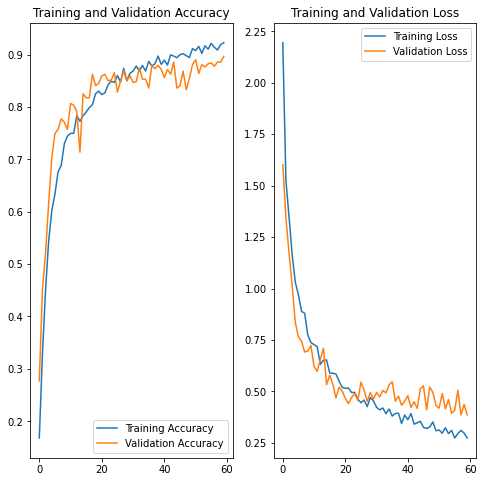

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model looks promising, both training and validation set accuracy and loss are very close to each other. We can see that the model is not overfit

In [97]:
model.save("./models/best_model.h5")

## Testing Model Accuracy

In [98]:
model = tf.keras.models.load_model('./models/best_model.h5')

This image most likely belongs to Pants with a 99.82 percent confidence.


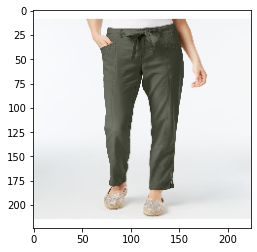

In [102]:
# test modle accuracy on some random image from google
img = tf.keras.utils.load_img(
    '../c77fe52d-a118-4f02-9388-c1abc0b8e825_1.cf22f3c5cac1aa0745812cc4f475c9a3.jpeg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [123]:
# model.predict(val_ds)
class_names

['Dress', 'Longsleeve', 'Pants', 'Shoes', 'T-Shirt']

In [103]:
predictions = model.predict(val_ds)
predictions_class = []

In [104]:
for i in predictions:
    predictions_class.append(np.argmax(i))

In [105]:
# convert tensor batches to numpy array
y_actual= []
for e in val_ds.as_numpy_iterator():
    y_actual.append(e)
y_actual = np.array(y_actual)
y_actual = np.concatenate(y_actual[:,1])

C:\Users\Qasim\AppData\Local\Temp/ipykernel_21272/2281519341.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_actual = np.array(y_actual)


In [106]:
from sklearn.metrics import classification_report

In [107]:
# the model performance is not bad even though the data was very small (about 2500 images total for all 5 classes)
print(classification_report(y_actual, np.array(predictions_class), target_names=class_names))

              precision    recall  f1-score   support

       Dress       0.78      0.88      0.82        75
  Longsleeve       0.89      0.82      0.86       134
       Pants       0.96      0.96      0.96       139
       Shoes       0.98      0.88      0.92        91
     T-Shirt       0.87      0.91      0.89       207

    accuracy                           0.90       646
   macro avg       0.90      0.89      0.89       646
weighted avg       0.90      0.90      0.90       646

